# Post-Review-Synthetic-Data-V4.1 Evaluation

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Input data files are available in the "./input_data/" directory.
import os
print(os.listdir("./input_data/final"))
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table

###################################
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.1
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

['clean_test_allFP.csv', 'clean_test_greedyFP.csv', 'clean_test_leakFP.csv', 'clean_test_suicidalFP.csv', 'clean_train.csv', 'LsMa', 'no_duplicates', 'old_no_duplicates']


### Defining functions

In [8]:
def label(df):    
    # label data
    df['LABEL'] = 0
    df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    df.loc[df['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
	
def preprocess(df):
    n_most_common_words = 1000 #8000
    max_len = 130

    # Class Tokenizer - This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
    # tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer = Tokenizer(num_words=n_most_common_words, lower=False)

    # fit_on_texts - Updates internal vocabulary based on a list of texts. In the case where texts contains lists, we assume each entry of the lists to be a token.
    # tokenizer.fit_on_texts(increased_vul['OPCODE'].values)
    tokenizer.fit_on_texts(df['OPCODE'].values)

    # # Transforms each text in texts in a sequence of integers.
    sequences = tokenizer.texts_to_sequences(df['OPCODE'].values)
    # sequences = tokenizer.texts_to_sequences(tt)

    #Find number of unique words/tokens
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #pad sequences with zeros in front to make them all maxlen
    X = pad_sequences(sequences, maxlen=max_len)
    return X
	
def dftoXY(df):
    # Save test X and y
    X_test = preprocess(df)
    # label data
    label(df)
#     df['LABEL'] = 0
#     df.loc[df['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
#     df.loc[df['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    print(pd.value_counts(df['LABEL']))
    y_test = to_categorical(df['LABEL'], num_classes=2)
    return X_test, y_test    

def XandY(posdf, negdf=None):
    dfset = pd.concat([posdf, negdf])
    dfset = dfset.sample(frac=1, random_state=39, replace=False)

    dfset['LABEL'] = 0

    #One-hot encode the lab
    dfset.loc[dfset['CATEGORY'] == '1 0 0 0', 'LABEL'] = 0
    dfset.loc[dfset['CATEGORY'] != '1 0 0 0', 'LABEL'] = 1
    # df_train.head()

    X, y = dftoXY(dfset)

    print('Shape of X: {}'.format(X.shape))

    # for sm.fit_sample
    y_labels = np.expand_dims(np.array(np.argmax(y, axis=1)), axis=1)
    print('Shape of y: {}'.format(y_labels.shape))

    return X, y_labels

def FPsplit(df, train_frac):
    msk = np.random.rand(len(df)) <= train_frac
    train_df = df[msk]
    test_df = df[~msk]
    return train_df, test_df


# Saving and Loading Trained Model

In [9]:
# model_name = "v3_550KLSTM64epoch100train0.64drop0.55"
model_name = "BEST_trainv4.1_10KLSTM32epoch80pat7drop0.5ratio0.5leak0.67"

In [10]:
# loading previously saved model
from keras.models import load_model
# model = load_model('./saved_model/postreviewV3/'+ 'train' + model_name + '.h5')
model = load_model('./saved_model/postreviewV4.1/'+ model_name + '.h5')

# Plot Performance

In [11]:
import pickle
# infile = open('./saved_model/postreviewV3/' + 'train' + model_name ,'rb')
infile = open('./saved_model/postreviewV4.1/' + model_name ,'rb')
history0 = pickle.load(infile)
infile.close()

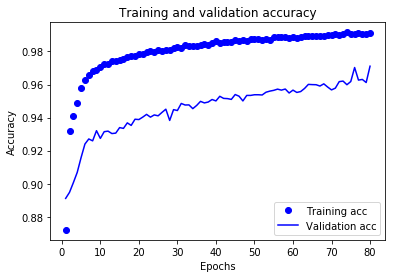

In [38]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history0['acc']
val_acc = history0['val_acc']
loss = history0['loss']
val_loss = history0['val_loss']


epochs = range(1, len(acc) + 1)

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# fig.savefig('./figures/postreviewV4.1/Accr_trainandval_' + model_name + '.png',dpi=300)

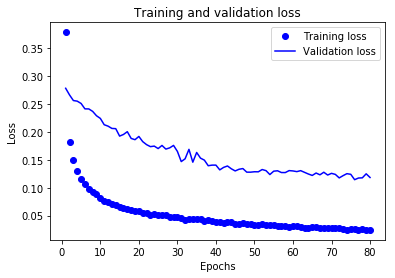

In [39]:
fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# fig.savefig('./figures/postreviewV4.1/Loss_trainandval_' + model_name + '.png',dpi=300)

# Collecting and saving flagged negatives for validation

# All test FPs

# ADDED Evaluation Measures

### Saving and Loading Trained Model

In [14]:
# model_name = "v3_550KLSTM64epoch100train0.64drop0.55"
model_name = "BEST_trainv4.1_10KLSTM32epoch80pat7drop0.5ratio0.5leak0.67"

In [15]:
# loading previously saved model
from keras.models import load_model
# model = load_model('./saved_model/postreviewV3/'+ 'train' + model_name + '.h5')
model = load_model('./saved_model/postreviewV4.1/'+ model_name + '.h5')

In [17]:
# split positives dataset into train, val, and test
proportion_train = 0.64 #0.7 
proportion_val = 0.16 #0.1 
proportion_test = 0.2 #0.20

# set number of samples in each set
num_neg_train = 10000 #550000 #350000 #30000 #11000

# Init
epochs = 80
emb_dim = 128 #150
batch_size = 256 #512   

# LSTM Model
# tune Dropout(0.6) and LSTM 64 or 32
ratioFP = 0.5
FPtrain_frac = 0.8
leak_frac = 0.67

dropout = 0.5
LSTM_units = 32 #64

In [18]:
# ============== Loading and reading csv input data ============== 
dataset = 'clean_train.csv'
data = pd.read_csv('./input_data/final/'+dataset, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])

# shuffled = data.reindex(np.random.permutation(data.index))
shuffled = data

# shuffled = data
n = shuffled[shuffled['CATEGORY'] == '1 0 0 0'] # no vulnerabilities
s = shuffled[shuffled['CATEGORY'] == '0 1 0 0'] # suicidal
p = shuffled[shuffled['CATEGORY'] == '0 0 1 0'] # prodigal
g = shuffled[shuffled['CATEGORY'] == '0 0 0 1'] # greedy
sp = shuffled[shuffled['CATEGORY'] == '0 1 1 0'] # suicidal and prodigal

# ========== set of vul contracts ========== 
# shuffle positives dataset
positives = pd.concat([s,p,g,sp])
positives_shuf = positives.sample(frac=1, random_state=39, replace=False)
print(len(positives_shuf))
	
# # split positives dataset into train, val, and test
# proportion_train = 0.64 #0.7 
# proportion_val = 0.16 #0.1 
# proportion_test = 0.2 #0.20
	
num_pos_train = round(len(positives_shuf) * proportion_train)
num_pos_val = round(len(positives_shuf) * proportion_val)

pos_train = positives_shuf.iloc[0:num_pos_train] 
pos_val = positives_shuf.iloc[num_pos_train:(num_pos_train+num_pos_val)]
pos_test = positives_shuf.iloc[(num_pos_train+num_pos_val):]
	
# ========== set of non-vul contracts ========== 
# # shuffle set n
n_shuf = n.sample(frac=1, random_state=39, replace=False)

n_shuf['FP'] = 0
# set number of samples in each set
# num_neg_train = 9000 #30000 #11000
num_neg_val = round(((num_neg_train)/proportion_train)*proportion_val)
num_neg_test = round(((num_neg_train)/proportion_train)*proportion_test)

neg_train = n_shuf.iloc[0:num_neg_train]
neg_val = n_shuf.iloc[num_neg_train:(num_neg_train+num_neg_val)]
neg_test = n_shuf.iloc[(num_neg_train+num_neg_val):(num_neg_train+num_neg_val+num_neg_test)]

8640


In [19]:
# ========== adding FPs into non-vul training set ========== 
# FPs = "clean_test_allFP_noDups.csv"
# allFPs = pd.read_csv('./input_data/final/no_duplicates/'+ FPs, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
# all_testset = 'clean_test_allFP_noDups.csv'
leakFP = 'clean_test_leakFP_noDups.csv'
suicidalFP = 'clean_test_suicidalFP_noDups.csv'
greedyFP = 'clean_test_greedyFP_noDups.csv'

leakFPs = pd.read_csv('./input_data/final/no_duplicates/'+leakFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
print("Total Number of Leak FPs: ", len(leakFPs))
suicidalFPs = pd.read_csv('./input_data/final/no_duplicates/'+suicidalFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
print("Total Number of Suicidal FPs: ", len(suicidalFPs))
greedyFPs = pd.read_csv('./input_data/final/no_duplicates/'+greedyFP, usecols=['ADDRESS', 'OPCODE', 'CATEGORY'])
print("Total Number of Greedy FPs: ", len(greedyFPs))

# Split FPs into training and test set
# FPtrain_frac = 0.8
def FPsplit(df, train_frac):
    msk = np.random.rand(len(df)) <= train_frac
    train_df = df[msk]
    test_df = df[~msk]
    return train_df, test_df

train_leakFPs, test_leakFPs = FPsplit(leakFPs, leak_frac)
print("Number of Leak FPs for Training: ", len(train_leakFPs))
print("Number of Leak FPs for Test: ", len(test_leakFPs))

train_suicidalFPs, test_suicidalFPs = FPsplit(suicidalFPs, FPtrain_frac)
print("Number of Suicidal FPs for Training: ", len(train_suicidalFPs))
print("Number of Suicidal FPs for Test: ", len(test_suicidalFPs))

train_lockFPs, test_lockFPs = FPsplit(greedyFPs, FPtrain_frac)
print("Number of Lock FPs for Training: ", len(train_lockFPs))
print("Number of Lock FPs for Test: ", len(test_lockFPs))

trainFPs = pd.concat([train_leakFPs, train_suicidalFPs, train_lockFPs])

# add column to classify FPs and non-FPs
trainFPs['FP'] = 1

numFPs = len(trainFPs)
# print("Number of Original Negatives: ", len(neg_train))
print("Number of FPs: ", numFPs) #allFPs

# set number of samples in each set
numtrainFPs = round(numFPs*proportion_train)
numvalFPs = round(numFPs*proportion_val)
numtestFPs = numFPs - numtrainFPs - numvalFPs

FP_train = trainFPs.iloc[0:numtrainFPs]
FP_val = trainFPs.iloc[numtrainFPs:(numtrainFPs+numvalFPs)]
FP_test = trainFPs.iloc[(numtrainFPs+numvalFPs):(numtrainFPs+numvalFPs+numtestFPs)]

	
# Concatenate dfs
negtrain_addFP = pd.concat([neg_train, FP_train])
negval_addFP = pd.concat([neg_val, FP_val])
negtest_addFP = pd.concat([neg_test, FP_test])
# Shuffle df
negtrain_addFP = negtrain_addFP.sample(frac=1, random_state=39, replace=False)
negval_addFP = negval_addFP.sample(frac=1, random_state=39, replace=False)
negtest_addFP = negtest_addFP.sample(frac=1, random_state=39, replace=False)
# Processing X and y
Xnegtrain_addFP = preprocess(negtrain_addFP)
ynegtrain_addFP = to_categorical(negtrain_addFP['FP'], num_classes=2)
Xnegval_addFP = preprocess(negval_addFP)
ynegval_addFP = to_categorical(negval_addFP['FP'], num_classes=2)
Xnegtest_addFP = preprocess(negtest_addFP)
ynegtest_addFP = to_categorical(negtest_addFP['FP'], num_classes=2)
# for sm.fit_sample
ynegtrain_addFP_labels = np.expand_dims(np.array(np.argmax(ynegtrain_addFP, axis=1)), axis=1)
print('Shape of X: {}'.format(Xnegtrain_addFP.shape))
print('Shape of y: {}'.format(ynegtrain_addFP_labels.shape))
ynegval_addFP_labels = np.expand_dims(np.array(np.argmax(ynegval_addFP, axis=1)), axis=1)
print('Shape of X: {}'.format(Xnegval_addFP.shape))
print('Shape of y: {}'.format(ynegval_addFP_labels.shape))
ynegtest_addFP_labels = np.expand_dims(np.array(np.argmax(ynegtest_addFP, axis=1)), axis=1)
print('Shape of X: {}'.format(Xnegtest_addFP.shape))
print('Shape of y: {}'.format(ynegtest_addFP_labels.shape))

# Prepare train set 
# Xneg_train, ynegtrain_labels = XandY(neg_train, allFPs, label='FP')
print("Number transactions X_negtrain dataset: ", Xnegtrain_addFP.shape)
print("Number transactions y_negtrain dataset: ", ynegtrain_addFP_labels.shape)
print("Before OverSampling, train counts of label '1': {}".format(sum(ynegtrain_addFP_labels==1)))
print("Before OverSampling, train counts of label '0': {}".format(sum(ynegtrain_addFP_labels==0)))
print("Before OverSampling, val counts of label '1': {}".format(sum(ynegval_addFP_labels==1)))
print("Before OverSampling, val counts of label '0': {}".format(sum(ynegval_addFP_labels==0)))
print("Before OverSampling, test counts of label '1': {}".format(sum(ynegtest_addFP_labels==1)))
print("Before OverSampling, test counts of label '0': {}".format(sum(ynegtest_addFP_labels==0)))

from imblearn.over_sampling import SMOTE
smt = SMOTE(ratio=ratioFP, random_state=39)

Xnegtrain_res, ynegtrain_res = smt.fit_sample(Xnegtrain_addFP, ynegtrain_addFP_labels.ravel())
Xnegval_res, ynegval_res = smt.fit_sample(Xnegval_addFP, ynegval_addFP_labels.ravel())
Xnegtest_res, ynegtest_res = smt.fit_sample(Xnegtest_addFP, ynegtest_addFP_labels.ravel())

print('After OverSampling, the shape of train_X: {}'.format(Xnegtrain_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(ynegtrain_res.shape))
print('After OverSampling, the shape of val_X: {}'.format(Xnegval_res.shape))
print('After OverSampling, the shape of val_y: {}'.format(ynegval_res.shape))
print('After OverSampling, the shape of test_X: {}'.format(Xnegtest_res.shape))
print('After OverSampling, the shape of test_y: {}'.format(ynegtest_res.shape))

# change all neg labels to zero
ynegtrain_res = np.zeros(len(ynegtrain_res))
ynegval_res = np.zeros(len(ynegval_res))
ynegtest_res = np.zeros(len(ynegtest_res))

Total Number of Leak FPs:  177
Total Number of Suicidal FPs:  72
Total Number of Greedy FPs:  202
Number of Leak FPs for Training:  118
Number of Leak FPs for Test:  59
Number of Suicidal FPs for Training:  58
Number of Suicidal FPs for Test:  14
Number of Lock FPs for Training:  160
Number of Lock FPs for Test:  42
Number of FPs:  336
Found 150 unique tokens.
Found 150 unique tokens.
Found 150 unique tokens.
Shape of X: (10215, 130)
Shape of y: (10215, 1)
Shape of X: (2554, 130)
Shape of y: (2554, 1)
Shape of X: (3192, 130)
Shape of y: (3192, 1)
Number transactions X_negtrain dataset:  (10215, 130)
Number transactions y_negtrain dataset:  (10215, 1)
Before OverSampling, train counts of label '1': [215]
Before OverSampling, train counts of label '0': [10000]
Before OverSampling, val counts of label '1': [54]
Before OverSampling, val counts of label '0': [2500]
Before OverSampling, test counts of label '1': [67]
Before OverSampling, test counts of label '0': [3125]
After OverSampling, t

/home/wesley/miniconda3/envs/deeplearn_CE7454/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/wesley/miniconda3/envs/deeplearn_CE7454/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/wesley/miniconda3/envs/deeplearn_CE7454/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.w

In [20]:
### ============ Resampling samples ============ ###
def arrayXandY(Xarray1, Xarray2, yarray1, yarray2):
    X = np.concatenate((Xarray1, Xarray2),axis=0)
    yarray2 = np.expand_dims(np.array(yarray2), axis=1)
    y_labels = np.concatenate((yarray1, yarray2),axis=0)
    
    return X, y_labels

# Prepare train set 
# X_train, ytrain_labels = XandY(pos_train, neg_train)
Xpos_train, ypostrain_labels = XandY(pos_train)
X_train, ytrain_labels = arrayXandY(Xpos_train, Xnegtrain_res, ypostrain_labels, ynegtrain_res)

# Prepare validation set 
Xpos_val, yposval_labels = XandY(pos_val)
X_val, yval_labels = arrayXandY(Xpos_val, Xnegval_res, yposval_labels, ynegval_res)

# Prepare test set 
Xpos_test, ypostest_labels = XandY(pos_test)
X_test, ytest_labels = arrayXandY(Xpos_test, Xnegtest_res, ypostest_labels, ynegtest_res)

from sklearn.utils import shuffle
# shuffle train set
X_train, ytrain_labels = shuffle(X_train, ytrain_labels, random_state=39)
X_val, yval_labels = shuffle(X_val, yval_labels, random_state=39)
X_test, ytest_labels = shuffle(X_test, ytest_labels, random_state=39)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", ytrain_labels.shape)
print("Number transactions X_val dataset: ", X_val.shape)
print("Number transactions y_val dataset: ", yval_labels.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", ytest_labels.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(ytrain_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(ytrain_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(yval_labels==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(yval_labels==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(ytest_labels==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(ytest_labels==0)))


Found 150 unique tokens.
1    5530
Name: LABEL, dtype: int64
Shape of X: (5530, 130)
Shape of y: (5530, 1)
Found 150 unique tokens.
1    1382
Name: LABEL, dtype: int64
Shape of X: (1382, 130)
Shape of y: (1382, 1)
Found 150 unique tokens.
1    1728
Name: LABEL, dtype: int64
Shape of X: (1728, 130)
Shape of y: (1728, 1)
Number transactions X_train dataset:  (20530, 130)
Number transactions y_train dataset:  (20530, 1)
Number transactions X_val dataset:  (5132, 130)
Number transactions y_val dataset:  (5132, 1)
Number transactions X_test dataset:  (6415, 130)
Number transactions y_test dataset:  (6415, 1)
Before OverSampling, counts of label '1': [5530]
Before OverSampling, counts of label '0': [15000]
Before OverSampling, counts of label '1': [1382]
Before OverSampling, counts of label '0': [3750]
Before OverSampling, counts of label '1': [1728]
Before OverSampling, counts of label '0': [4687] 



In [21]:
# ============ Resample ============ 
# from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=39)
X_train_res, y_train_res = sm.fit_sample(X_train, ytrain_labels.ravel())
X_val_res, y_val_res = sm.fit_sample(X_val, yval_labels.ravel())
X_test_res, y_test_res = sm.fit_sample(X_test, ytest_labels.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train_res.shape))
print('After OverSampling, the shape of val_X: {}'.format(X_val_res.shape))
print('After OverSampling, the shape of val_y: {}'.format(y_val_res.shape))
print('After OverSampling, the shape of test_X: {}'.format(X_test_res.shape))
print('After OverSampling, the shape of test_y: {} \n'.format(y_test_res.shape))

print("After OverSampling, counts of train label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of train label '0': {}".format(sum(y_train_res==0)))
print("After OverSampling, counts of val label '1': {}".format(sum(y_val_res==1)))
print("After OverSampling, counts of val label '0': {}".format(sum(y_val_res==0)))
print("After OverSampling, counts of test label '1': {}".format(sum(y_test_res==1)))
print("After OverSampling, counts of test label '0': {}".format(sum(y_test_res==0)))


After OverSampling, the shape of train_X: (30000, 130)
After OverSampling, the shape of train_y: (30000,)
After OverSampling, the shape of val_X: (7500, 130)
After OverSampling, the shape of val_y: (7500,)
After OverSampling, the shape of test_X: (9374, 130)
After OverSampling, the shape of test_y: (9374,) 

After OverSampling, counts of train label '1': 15000
After OverSampling, counts of train label '0': 15000
After OverSampling, counts of val label '1': 3750
After OverSampling, counts of val label '0': 3750
After OverSampling, counts of test label '1': 4687
After OverSampling, counts of test label '0': 4687


In [32]:
# ============== Evaluation ==============

# Test accuracy
ytestres_cat = to_categorical(y_test_res, num_classes=2)
accr = model.evaluate(X_test_res, ytestres_cat)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

# To calculate precision and recall
y_pred = model.predict_classes(X_test_res, batch_size=32, verbose=0)
ytest_true = y_test_res

from sklearn.metrics import average_precision_score
# Compute the average precision score
average_precision = average_precision_score(ytest_true, y_pred)
print('Average Precision Score: {:0.4f}\n'.format(average_precision))

# Compute the recall
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(ytest_true, y_pred)
print('Recall Score: {:0.4f}\n'.format(recall[1]))

Average Precision Score: 0.9566

Recall Score: 0.9462



In [33]:
# ============== ADDED Evaluation ==============
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

# print('Accuracy:', accuracy_score(ytest_true, y_pred))
# print('Recall:', recall_score(ytest_true, y_pred))
# print('Precision:', precision_score(ytest_true, y_pred))
# print('F1 score:', f1_score(ytest_true, y_pred))
# print('\n clasification report:\n', classification_report(ytest_true, y_pred))
# print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

In [34]:
# The set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
print('Accuracy: {:0.4f}\n'.format(accuracy_score(ytest_true, y_pred)))
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
print('Recall: {:0.4f}\n'.format(recall_score(ytest_true, y_pred)))
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('Precision: {:0.4f}\n'.format(precision_score(ytest_true, y_pred)))
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
print('F1 score: {:0.4f}\n'.format(f1_score(ytest_true, y_pred)))

# In binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))
# Overview of all scores
print('\n clasification report:\n', classification_report(ytest_true, y_pred))

Accuracy: 0.9647

Recall: 0.9462

Precision: 0.9825

F1 score: 0.9640


 confusion matrix:
 [[4608   79]
 [ 252 4435]]

 clasification report:
              precision    recall  f1-score   support

        0.0       0.95      0.98      0.97      4687
        1.0       0.98      0.95      0.96      4687

avg / total       0.97      0.96      0.96      9374



In [35]:
from sklearn.metrics import roc_curve, auc, roc_auc_score    
# Compute Receiver operating characteristic (ROC). Restricted to the binary classification task
fpr, tpr, threshold = roc_curve(ytest_true, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC score: {:0.4f}\n'.format(roc_auc_score(ytest_true, y_pred)))

ROC AUC score: 0.9647



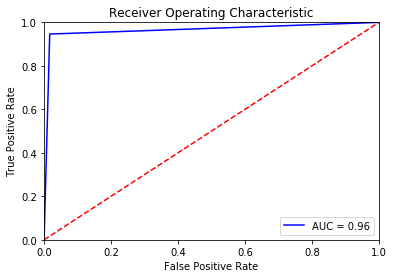

In [40]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
## plt.show()
# plt.savefig('./figures/postreviewV4.1/ROC_' + model_name + '.png', dpi=300)

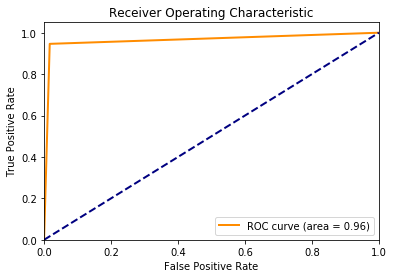

In [41]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
## plt.show()
# plt.savefig('./figures/postreviewV4.1/ROCnice_' + model_name + '.png',dpi=300)